In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
def findFiles(path): return glob.glob(path)

file_path = '../data/RNN_data/names/*.txt'

print(findFiles(file_path))

['../data/RNN_data/names/Czech.txt', '../data/RNN_data/names/Scottish.txt', '../data/RNN_data/names/Irish.txt', '../data/RNN_data/names/Vietnamese.txt', '../data/RNN_data/names/English.txt', '../data/RNN_data/names/German.txt', '../data/RNN_data/names/Greek.txt', '../data/RNN_data/names/Portuguese.txt', '../data/RNN_data/names/Russian.txt', '../data/RNN_data/names/Spanish.txt', '../data/RNN_data/names/Arabic.txt', '../data/RNN_data/names/Dutch.txt', '../data/RNN_data/names/Polish.txt', '../data/RNN_data/names/Korean.txt', '../data/RNN_data/names/French.txt', '../data/RNN_data/names/Italian.txt', '../data/RNN_data/names/Japanese.txt', '../data/RNN_data/names/Chinese.txt']


In [3]:
all_letters = string.ascii_letters + ".,;''"
n_letters = len(all_letters)

# 유니코드 문자열을 ASCII로 변환, https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

Slusarski


In [4]:
category_lines = {}
all_categories = []

# read & split file
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles(file_path):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines
    
n_categories = len(all_categories)

print("category : {num}".format(num=n_categories))
print("category keys :", all_categories)
print(category_lines['Korean'][:5])

category : 18
category keys : ['Czech', 'Scottish', 'Irish', 'Vietnamese', 'English', 'German', 'Greek', 'Portuguese', 'Russian', 'Spanish', 'Arabic', 'Dutch', 'Polish', 'Korean', 'French', 'Italian', 'Japanese', 'Chinese']
['Ahn', 'Baik', 'Bang', 'Byon', 'Cha']


In [5]:
# ex) "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# One-Hot vector
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

In [6]:
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor
print(letterToTensor('j'))
print(lineToTensor('Jun').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([3, 1, 57])


In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
batch_size = 4
num_workers = 2
epochs = 4
learning_rate = 0.001
betas = (0.9, 0.999)
n_iters = 1000000
plot_every = 1000

In [8]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        # input to hidden
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        # input to output
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        out = self.i2o(combined)
        out = self.softmax(out)
        
        return out, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    
n_hidden = 128
net = RNN(n_letters, n_hidden, n_categories)

if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    net = nn.DataParallel(net)
net.to(device)

RNN(
  (i2h): Linear(in_features=185, out_features=128, bias=True)
  (i2o): Linear(in_features=185, out_features=18, bias=True)
  (softmax): LogSoftmax()
)

In [9]:
input = letterToTensor('A')
# initial hidden layer
hidden = torch.zeros(1, n_hidden)

input = input.to(device)
hidden = hidden.to(device)

output, next_hidden = net(input, hidden)
print(output)

tensor([[-2.8974, -2.8064, -2.8123, -2.9018, -3.0204, -2.8247, -2.8050, -2.8473,
         -2.8194, -2.7833, -2.9809, -2.9642, -2.9602, -2.9094, -3.0002, -2.9044,
         -2.9178, -2.9178]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)


In [10]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate, betas=betas)

In [11]:
import random

def categoryFromOutput(output):
    top_n, top_i = output.topk(1) # 텐서의 가장 큰 값 및 주소
    category_i = top_i[0].item()     # 텐서에서 정수 값으로 변경
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

('Spanish', 9)
category = Polish / line = Dubicki
category = Czech / line = Zaruba
category = Irish / line = Caomh
category = Italian / line = Accosi
category = Scottish / line = Scott
category = French / line = Sauvageon
category = Czech / line = Stary
category = English / line = Kinnison
category = German / line = Maier
category = Scottish / line = Anderson


In [12]:
running_loss = 0
all_losses = []
for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    
    hidden = net.initHidden()

    net.zero_grad()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = net(line_tensor[i].to(device), hidden.to(device))
    
    loss = criterion(output, category_tensor.to(device))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    running_loss += loss.item()
    if iter % 1000 == 0:
        print("[{iter}] loss: {loss}".format(iter = iter, loss = running_loss / iter))
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print("{loss} {line} / {guess} {correct}".format(loss=loss.item, line=line, guess=guess, correct=correct))
    if iter % plot_every == 0:
        all_losses.append(running_loss / iter)
print("loss: {loss}".format(loss = running_loss / n_iters ))
print("Finished Training")
    
    

[1000] loss: 2.673097291588783
<built-in method item of Tensor object at 0x7fba3626aeb0> Buren / German ✗ (Dutch)
[2000] loss: 2.517517434477806
<built-in method item of Tensor object at 0x7fba362741e0> Venn / Chinese ✗ (Dutch)
[3000] loss: 2.397790719628334
<built-in method item of Tensor object at 0x7fba3626adc0> Bakastov / Japanese ✗ (Russian)
[4000] loss: 2.304619208008051
<built-in method item of Tensor object at 0x7fba36274280> Issa / Czech ✗ (Arabic)
[5000] loss: 2.2254979512929918
<built-in method item of Tensor object at 0x7fba3626af00> Seif / Arabic ✓
[6000] loss: 2.169151543279489
<built-in method item of Tensor object at 0x7fba3626af00> Gosse / Scottish ✗ (French)
[7000] loss: 2.114391681943621
<built-in method item of Tensor object at 0x7fba36274140> Kacirek / Dutch ✗ (Czech)
[8000] loss: 2.062414623782039
<built-in method item of Tensor object at 0x7fba3626aa50> Sin / Korean ✓
[9000] loss: 2.0218978747526806
<built-in method item of Tensor object at 0x7fba36274280> Lobo /

[73000] loss: 1.4406018121634445
<built-in method item of Tensor object at 0x7fba3626acd0> Vuong / Chinese ✗ (Vietnamese)
[74000] loss: 1.437817979434052
<built-in method item of Tensor object at 0x7fba3626af50> Tsang / Chinese ✓
[75000] loss: 1.4348645297702154
<built-in method item of Tensor object at 0x7fba36274140> Jones / Spanish ✗ (Scottish)
[76000] loss: 1.4324008247820954
<built-in method item of Tensor object at 0x7fba3626acd0> Dressler / German ✓
[77000] loss: 1.429347311509894
<built-in method item of Tensor object at 0x7fba3626aa50> Bach / Vietnamese ✓
[78000] loss: 1.4268508177644168
<built-in method item of Tensor object at 0x7fba36274280> Barros / Portuguese ✓
[79000] loss: 1.4244977487152135
<built-in method item of Tensor object at 0x7fba3626a640> Olmos / Greek ✗ (Spanish)
[80000] loss: 1.422071119940281
<built-in method item of Tensor object at 0x7fba3626a640> Duval / Czech ✗ (French)
[81000] loss: 1.4194392656360144
<built-in method item of Tensor object at 0x7fba900

[145000] loss: 1.3189299897995488
<built-in method item of Tensor object at 0x7fba3626acd0> Strand / German ✓
[146000] loss: 1.3178701982445096
<built-in method item of Tensor object at 0x7fba3626afa0> Thi / Chinese ✗ (Vietnamese)
[147000] loss: 1.3176388394755572
<built-in method item of Tensor object at 0x7fba3626aeb0> Bui / Vietnamese ✓
[148000] loss: 1.317222018658712
<built-in method item of Tensor object at 0x7fba3626acd0> Vargas / Greek ✗ (Portuguese)
[149000] loss: 1.3163659818808504
<built-in method item of Tensor object at 0x7fba3626afa0> Baik / Korean ✓
[150000] loss: 1.3152088482077917
<built-in method item of Tensor object at 0x7fba36274140> Kijek / Polish ✓
[151000] loss: 1.314384296329211
<built-in method item of Tensor object at 0x7fba3626afa0> Rompa / Italian ✗ (Dutch)
[152000] loss: 1.3131379389786406
<built-in method item of Tensor object at 0x7fba3626afa0> Aart / French ✗ (Dutch)
[153000] loss: 1.31246811080836
<built-in method item of Tensor object at 0x7fba3627428

[217000] loss: 1.2621411225020474
<built-in method item of Tensor object at 0x7fba3626adc0> Sugiyama / Japanese ✓
[218000] loss: 1.2613534649806695
<built-in method item of Tensor object at 0x7fba3626a640> Dounias / Greek ✓
[219000] loss: 1.2609834022876472
<built-in method item of Tensor object at 0x7fba3626ab90> Higuchi / Japanese ✓
[220000] loss: 1.2603586988406426
<built-in method item of Tensor object at 0x7fba3626aeb0> Ruzzier / Czech ✗ (Italian)
[221000] loss: 1.2595626710300667
<built-in method item of Tensor object at 0x7fba3626acd0> Macdonald / Scottish ✓
[222000] loss: 1.2591326344540124
<built-in method item of Tensor object at 0x7fba3626af50> Homer / German ✗ (English)
[223000] loss: 1.2583508759575974
<built-in method item of Tensor object at 0x7fba3626acd0> Uesugi / Japanese ✓
[224000] loss: 1.2578118094191886
<built-in method item of Tensor object at 0x7fba3626af50> Poingdestre / Italian ✗ (French)
[225000] loss: 1.257232766555945
<built-in method item of Tensor object 

[289000] loss: 1.2274762157761978
<built-in method item of Tensor object at 0x7fba3626adc0> Anstee / Spanish ✗ (English)
[290000] loss: 1.227282755673163
<built-in method item of Tensor object at 0x7fba3626adc0> Svotchak / Czech ✓
[291000] loss: 1.2271320987987713
<built-in method item of Tensor object at 0x7fba3626af00> Polites / Portuguese ✗ (Greek)
[292000] loss: 1.2266963553423802
<built-in method item of Tensor object at 0x7fba3626af00> Panzavecchia / Czech ✗ (Italian)
[293000] loss: 1.2263764929263106
<built-in method item of Tensor object at 0x7fba3626aeb0> Grzeskiewicz / Polish ✓
[294000] loss: 1.2258555898907386
<built-in method item of Tensor object at 0x7fba3626a640> Aylott / English ✓
[295000] loss: 1.225455529371889
<built-in method item of Tensor object at 0x7fba3626aeb0> Maes / Portuguese ✗ (Dutch)
[296000] loss: 1.2252758270072173
<built-in method item of Tensor object at 0x7fba3626a640> Sze / Chinese ✓
[297000] loss: 1.2249348240405422
<built-in method item of Tensor o

[361000] loss: 1.2039260864376795
<built-in method item of Tensor object at 0x7fba3626aa50> Cassidy / Irish ✓
[362000] loss: 1.2037670859780616
<built-in method item of Tensor object at 0x7fba3626ab90> Victors / French ✓
[363000] loss: 1.2034211404163175
<built-in method item of Tensor object at 0x7fba3626a640> Augustin / Russian ✗ (French)
[364000] loss: 1.2032082869540592
<built-in method item of Tensor object at 0x7fba3626af00> Pasternack / Polish ✓
[365000] loss: 1.2027695019030407
<built-in method item of Tensor object at 0x7fba3626a640> Gatsuk / Arabic ✗ (Russian)
[366000] loss: 1.2025146225623664
<built-in method item of Tensor object at 0x7fba3626adc0> Jelinek / Polish ✗ (Czech)
[367000] loss: 1.2022584533483114
<built-in method item of Tensor object at 0x7fba3626acd0> Taka / Japanese ✓
[368000] loss: 1.2019537301664038
<built-in method item of Tensor object at 0x7fba3626acd0> Jernevsky / English ✗ (Russian)
[369000] loss: 1.2015490069456782
<built-in method item of Tensor obje

[433000] loss: 1.1863198356346913
<built-in method item of Tensor object at 0x7fba3626afa0> Ha / Vietnamese ✓
[434000] loss: 1.186132084294793
<built-in method item of Tensor object at 0x7fba3626a640> Czabal / Polish ✗ (Czech)
[435000] loss: 1.1858671546764759
<built-in method item of Tensor object at 0x7fba3626adc0> Jatskevich / Russian ✓
[436000] loss: 1.1857333275238822
<built-in method item of Tensor object at 0x7fba3626adc0> Obando / Spanish ✓
[437000] loss: 1.1855430101091107
<built-in method item of Tensor object at 0x7fba3626aeb0> Than / Vietnamese ✓
[438000] loss: 1.1854701702707537
<built-in method item of Tensor object at 0x7fba3626af50> Ross / English ✗ (Scottish)
[439000] loss: 1.1851760533529425
<built-in method item of Tensor object at 0x7fba3626adc0> Birk / Czech ✗ (Russian)
[440000] loss: 1.1849802673360417
<built-in method item of Tensor object at 0x7fba3626ab90> Muhlbauer / German ✗ (Czech)
[441000] loss: 1.184708585153471
<built-in method item of Tensor object at 0x

[505000] loss: 1.1741936767842593
<built-in method item of Tensor object at 0x7fba3626afa0> Berti / Italian ✓
[506000] loss: 1.174105525962781
<built-in method item of Tensor object at 0x7fba3626aeb0> Ko / Korean ✓
[507000] loss: 1.1738537723166873
<built-in method item of Tensor object at 0x7fba3626aa50> Simpson / Scottish ✓
[508000] loss: 1.1737180895494292
<built-in method item of Tensor object at 0x7fba3626af00> Murphy / Irish ✓
[509000] loss: 1.1735565265616108
<built-in method item of Tensor object at 0x7fba3626a640> Germain / Irish ✗ (French)
[510000] loss: 1.1733730941269702
<built-in method item of Tensor object at 0x7fba3626ab90> Romeijnsen / Dutch ✓
[511000] loss: 1.1732467184326896
<built-in method item of Tensor object at 0x7fba3626a640> Antar / Arabic ✓
[512000] loss: 1.1730447430071953
<built-in method item of Tensor object at 0x7fba3626af50> Kira / Japanese ✓
[513000] loss: 1.1729159843741723
<built-in method item of Tensor object at 0x7fba3626a640> Aldana / Spanish ✓
[

[577000] loss: 1.1650342437727716
<built-in method item of Tensor object at 0x7fba3626afa0> Castillion / French ✗ (Spanish)
[578000] loss: 1.164950225215995
<built-in method item of Tensor object at 0x7fba3626a640> Tchehovich / English ✗ (Russian)
[579000] loss: 1.1648668308887882
<built-in method item of Tensor object at 0x7fba3626adc0> Auttenberg / Dutch ✗ (Polish)
[580000] loss: 1.1649516515537583
<built-in method item of Tensor object at 0x7fba3626afa0> Karnoupakis / Greek ✓
[581000] loss: 1.164724433451256
<built-in method item of Tensor object at 0x7fba3626af00> Gai / Chinese ✓
[582000] loss: 1.1645292422577316
<built-in method item of Tensor object at 0x7fba3626ab90> Abello / Italian ✓
[583000] loss: 1.1643678843876983
<built-in method item of Tensor object at 0x7fba3626aa50> Ochida / Japanese ✓
[584000] loss: 1.164201881754984
<built-in method item of Tensor object at 0x7fba3626aa50> Blumstein / German ✓
[585000] loss: 1.1639373429709712
<built-in method item of Tensor object a

[649000] loss: 1.157721983334097
<built-in method item of Tensor object at 0x7fba3626adc0> Rutkowski / Polish ✓
[650000] loss: 1.1576465448064772
<built-in method item of Tensor object at 0x7fba3626a640> Hamaguchi / Japanese ✓
[651000] loss: 1.1575895412057287
<built-in method item of Tensor object at 0x7fba3626aa50> Jagodin / Irish ✗ (Russian)
[652000] loss: 1.157437364270849
<built-in method item of Tensor object at 0x7fba3626adc0> Smit / French ✗ (Dutch)
[653000] loss: 1.1573422766199113
<built-in method item of Tensor object at 0x7fba3626a640> Ho / Vietnamese ✗ (Korean)
[654000] loss: 1.1571899244401116
<built-in method item of Tensor object at 0x7fba3626a640> Trinh / Vietnamese ✓
[655000] loss: 1.1570796887689376
<built-in method item of Tensor object at 0x7fba3626adc0> Durante / English ✗ (Italian)
[656000] loss: 1.1570398033873885
<built-in method item of Tensor object at 0x7fba3626ab90> Reiher / Dutch ✗ (German)
[657000] loss: 1.1569510842267172
<built-in method item of Tensor 

[720000] loss: 1.15191552386027
<built-in method item of Tensor object at 0x7fba3626aa50> Tani / Vietnamese ✗ (Japanese)
[721000] loss: 1.1518491602248688
<built-in method item of Tensor object at 0x7fba36274280> Fionn / Irish ✓
[722000] loss: 1.151781841811002
<built-in method item of Tensor object at 0x7fba3626af00> Kowalczyk / Polish ✓
[723000] loss: 1.1516667980813549
<built-in method item of Tensor object at 0x7fba3626af50> Frost / German ✓
[724000] loss: 1.151602307702675
<built-in method item of Tensor object at 0x7fba3626acd0> Uerling / German ✗ (Czech)
[725000] loss: 1.1515317054302403
<built-in method item of Tensor object at 0x7fba3626acd0> Jin / Chinese ✓
[726000] loss: 1.1514521572116803
<built-in method item of Tensor object at 0x7fba3626ab90> Kikutake / Japanese ✓
[727000] loss: 1.151436506569737
<built-in method item of Tensor object at 0x7fba3626afa0> Kano / Japanese ✓
[728000] loss: 1.151355763914051
<built-in method item of Tensor object at 0x7fba3626af00> Awtaeff / 

[792000] loss: 1.1472794208269759
<built-in method item of Tensor object at 0x7fba3626af50> Porter / German ✗ (English)
[793000] loss: 1.1472208397207164
<built-in method item of Tensor object at 0x7fba3626af50> Martinez / Spanish ✓
[794000] loss: 1.1469938295051887
<built-in method item of Tensor object at 0x7fba3626ab90> Cen / Korean ✗ (Chinese)
[795000] loss: 1.1469261516243725
<built-in method item of Tensor object at 0x7fba3626ab90> Avkhimovich / Russian ✓
[796000] loss: 1.1468781185757884
<built-in method item of Tensor object at 0x7fba3626ab90> Tillens / English ✗ (Dutch)
[797000] loss: 1.1468483032349868
<built-in method item of Tensor object at 0x7fba3626aa50> Diep / Vietnamese ✓
[798000] loss: 1.1467750667436016
<built-in method item of Tensor object at 0x7fba3626ab90> Salamanca / Italian ✗ (Spanish)
[799000] loss: 1.1467621684696596
<built-in method item of Tensor object at 0x7fba3626aa50> Ungaro / Japanese ✗ (Italian)
[800000] loss: 1.146732293740757
<built-in method item o

[864000] loss: 1.1431592714154752
<built-in method item of Tensor object at 0x7fba3626acd0> Chun / Chinese ✗ (Korean)
[865000] loss: 1.1429432733224019
<built-in method item of Tensor object at 0x7fba3626a640> Zambrano / Scottish ✗ (Spanish)
[866000] loss: 1.1429282799202136
<built-in method item of Tensor object at 0x7fba3626af00> Bosko / Polish ✓
[867000] loss: 1.1429300108964051
<built-in method item of Tensor object at 0x7fba3626aa50> Laurent / French ✓
[868000] loss: 1.142874025098397
<built-in method item of Tensor object at 0x7fba3626aa50> Royer / Dutch ✗ (French)
[869000] loss: 1.142748795785783
<built-in method item of Tensor object at 0x7fba3626aa50> Vykruta / Czech ✓
[870000] loss: 1.1426948758770779
<built-in method item of Tensor object at 0x7fba3626aa50> Bairak / Arabic ✗ (Russian)
[871000] loss: 1.1427383652272873
<built-in method item of Tensor object at 0x7fba3626acd0> Marie / French ✓
[872000] loss: 1.1426264960607175
<built-in method item of Tensor object at 0x7fba36

[936000] loss: 1.139312510869838
<built-in method item of Tensor object at 0x7fba3626ab90> Chevalier / French ✓
[937000] loss: 1.139345846963147
<built-in method item of Tensor object at 0x7fba3626acd0> Brannon / French ✗ (Irish)
[938000] loss: 1.1393904725981367
<built-in method item of Tensor object at 0x7fba3626aa50> Daal / Arabic ✗ (Dutch)
[939000] loss: 1.1393226953270967
<built-in method item of Tensor object at 0x7fba3626af00> Bradan / Irish ✓
[940000] loss: 1.1392619806181414
<built-in method item of Tensor object at 0x7fba3626af00> Mikhail / Russian ✗ (Arabic)
[941000] loss: 1.1392576203907414
<built-in method item of Tensor object at 0x7fba3626af00> Sakelaris / Greek ✓
[942000] loss: 1.1392638851004524
<built-in method item of Tensor object at 0x7fba3626ab90> Chang / Korean ✓
[943000] loss: 1.1391739335780342
<built-in method item of Tensor object at 0x7fba3626aeb0> Monfort / French ✗ (Czech)
[944000] loss: 1.1390848823007351
<built-in method item of Tensor object at 0x7fba36

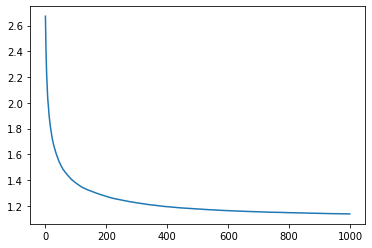

In [13]:
# Loss result
plt.figure()
plt.plot(all_losses)

# Evaluation

In [14]:
net.eval()

correct = 0
total = 0

with torch.no_grad():
    for key in category_lines:
        for line in category_lines[key]:
            input = lineToTensor(line)
            category = torch.tensor([all_categories.index(key)], dtype=torch.long).to(device)
           
            hidden = net.initHidden()
            for i in range(input.size()[0]):
                output, hidden = net(input[i].to(device), hidden.to(device))
            
            _, predicted = torch.max(output.data, 1)
            total += category.size(0)
            correct += (predicted == category).sum().item()
print('Accuracy of the network on the 10000 test images: {}'.format(
    100 * correct / total))

Accuracy of the network on the 10000 test images: 62.07532131114875
